In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import nibabel
import nibabel.processing
import os
from skimage.filters import threshold_otsu
import cc3d
import shutil
import pickle
import keras_tuner as kt
import random
from scipy import ndimage

In [ ]:
"""PLEASE NOTE THAT BECAUSE A VERSION WITH 81 CONVERTERS WAS USED FIRST, EVERY MENTION OF THE FOLDS SHOULD CARRY
THE NUMBER 2, REFERENCING THE 106 FINAL DATASET

In [2]:
#USE SMALL GPU#
use_gpu = 1 
# The largest memory size GPU is always the first one (0) as they are sorted by size!
gpus=tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[use_gpu], 'GPU')

In [ ]:
#Load datasets

In [3]:
with open('f1spec2.pickle', 'rb') as f:
     spec1 = pickle.load(f)
with open('f2spec2.pickle', 'rb') as f:
     spec2 = pickle.load(f)
with open('f3spec2.pickle', 'rb') as f:
     spec3 = pickle.load(f)
with open('f4spec2.pickle', 'rb') as f:
     spec4 = pickle.load(f)
with open('f5spec2.pickle', 'rb') as f:
     spec5 = pickle.load(f)

In [4]:
f1train_loader=tf.data.experimental.load("./datasets/fold1train2",element_spec=spec1)
f1validation_loader=tf.data.experimental.load("./datasets/fold1val2",element_spec=spec1)

f2train_loader=tf.data.experimental.load("./datasets/fold2train2",element_spec=spec2)
f2validation_loader=tf.data.experimental.load("./datasets/fold2val2",element_spec=spec2)

f3train_loader=tf.data.experimental.load("./datasets/fold3train2",element_spec=spec3)
f3validation_loader=tf.data.experimental.load("./datasets/fold3val2",element_spec=spec3)

f4train_loader=tf.data.experimental.load("./datasets/fold4train2",element_spec=spec4)
f4validation_loader=tf.data.experimental.load("./datasets/fold4val2",element_spec=spec4)

f5train_loader=tf.data.experimental.load("./datasets/fold5train2",element_spec=spec5)
f5validation_loader=tf.data.experimental.load("./datasets/fold5val2",element_spec=spec5)

In [ ]:
#Data augmentation

In [5]:
@tf.function
def rotate(volume):
    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


@tf.function
def shift(volume):
    def scipy_shift(volume):
        offsets = [-20, -10, -5, 5, 10, 20, 0]
        offset1 = random.choice(offsets)
        offset2 = random.choice(offsets)
        volume=ndimage.interpolation.shift(volume, (int(offset1), int(offset2), 0), order=5, mode='nearest')
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume
    augmented_volume = tf.numpy_function(scipy_shift, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by __Data_Aug__ and adding a channel."""
    
    volume = shift(volume)
    
    volume = rotate(volume)
   
    volume = tf.expand_dims(volume, axis=3)
    
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
#Batch size and loading

In [6]:
batch_size = 8

f1train_dataset = (
    f1train_loader.shuffle(tf.data.experimental.cardinality(f1train_loader).numpy()).map(train_preprocessing).batch(batch_size).prefetch(2)
)

f1validation_dataset = (
    f1validation_loader.map(validation_preprocessing).batch(batch_size).prefetch(2)
)

f2train_dataset = (
    f2train_loader.shuffle(tf.data.experimental.cardinality(f2train_loader).numpy()).map(train_preprocessing).batch(batch_size).prefetch(2)
)

f2validation_dataset = (
    f2validation_loader.map(validation_preprocessing).batch(batch_size).prefetch(2)
)


f3train_dataset = (
    f3train_loader.shuffle(tf.data.experimental.cardinality(f3train_loader).numpy()).map(train_preprocessing).batch(batch_size).prefetch(2)
)

f3validation_dataset = (
    f3validation_loader.map(validation_preprocessing).batch(batch_size).prefetch(2)
)


f4train_dataset = (
    f4train_loader.shuffle(tf.data.experimental.cardinality(f4train_loader).numpy()).map(train_preprocessing).batch(batch_size).prefetch(2)
)

f4validation_dataset = (
    f4validation_loader.map(validation_preprocessing).batch(batch_size).prefetch(2)
)


f5train_dataset = (
    f5train_loader.shuffle(tf.data.experimental.cardinality(f5train_loader).numpy()).map(train_preprocessing).batch(batch_size).prefetch(2)
)

f5validation_dataset = (
    f5validation_loader.map(validation_preprocessing).batch(batch_size).prefetch(2)
)

In [ ]:
#Checking loaders

Got data
Got labels
Got numpy
Dimension of the scan is: (100, 100, 90, 1)


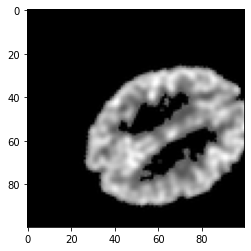

In [7]:
data = f5train_dataset.take(1)
print("Got data")
images, labels = list(data)[0]
print("Got labels")
images = images.numpy()
print("Got numpy")
image = images[0]
print("Dimension of the scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 50]), cmap="gray")
#plt.hist(np.ndarray.flatten(image))

In [ ]:
#Define metrics

In [8]:
metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.AUC()]

In [ ]:
def get_model():
    model=tf.keras.models.load_model("/local_mount/space/celer/1/users/notebooks/moises/saved_models/reproducing_b_simplecnn2/epoch28")
    #for layer in model.layers[0:29]:
        #layer.trainable=False
        #print(layer.name,"is now frozen")
    
    metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.AUC()]
    
    lr = 0.0001

    model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=metrics)
    
    return model
    

In [ ]:
#Training loop, it traverses all folds using the snippet at the beginning, then does the same for each one. 
#Metrics are saved into an object that can be then exported, I used this to check what model performed best

In [ ]:
train_dataset=0
validation_dataset=0
metris=[]
for i in range(5):
    if i==0:
        train_dataset=f1train_dataset
        validation_dataset=f1validation_dataset
    elif i==1:
        train_dataset=f2train_dataset
        validation_dataset=f2validation_dataset
    elif i==2:
        train_dataset=f3train_dataset
        validation_dataset=f3validation_dataset
    elif i==3:
        train_dataset=f4train_dataset
        validation_dataset=f4validation_dataset
    else:
        train_dataset=f5train_dataset
        validation_dataset=f5validation_dataset
    
    model=get_model()
    
    log_dir = "my_log_dir/newconv_rep2smallcnn{}".format(i)
    modelpath=("saved_models/newconv_rep2smallcnn{0}".format(i))

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(modelpath,"epoch{epoch}"),
            save_best_only=True,  
            monitor="val_loss",
            verbose=1),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                   histogram_freq=1,
                                   embeddings_freq=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=5, min_lr=0.000001),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
    
    print("Model {} training".format(i))
    
    model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    shuffle=True,
    verbose=1, 
    callbacks=callbacks)
    
    print("Model {} finished training".format(i))
    
    a=model.evaluate(validation_dataset)
    
    metris.append("Fold{}".format(i))
    
    metris.append(a)  
    
    print("Saved metrics")
    

In [ ]:
metris

In [12]:
import csv

In [13]:
with open('###INSERT MODEL TESTED#####', 'w') as f:

    write = csv.writer(f)

    write.writerows(metris)